In [1]:
import numpy as np
import cv2
from skimage import io
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import matplotlib.pyplot as plt
%matplotlib inline


def get_obj2img_rate():
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    return xm_per_pix,ym_per_pix

def get_obj2img_points():

    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    #images = glob.glob('../camera_cal/calibration*.jpg')
    images = glob.glob('./camera_cal/calibration*.jpg')

    # Step through the list and search for chessboard corners
    for fname in images:
        img = io.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
        #print(corners.shape)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

    #print(len(imgpoints))
    return ret,images,objpoints,imgpoints



def get_cal_undistort_param(img_size , objpoints, imgpoints):
    
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
   
    return ret,mtx,dist



gbl_img_sizeX = -1
gbl_img_sizeY = -1


def get_list_img_sizeYX():
    global gbl_img_sizeX
    global gbl_img_sizeY
    
    if(gbl_img_sizeX<=0):
        img = io.imread('./camera_cal/calibration1.jpg')
        gbl_img_sizeX=img.shape[0]
        gbl_img_sizeY=img.shape[1]
    
    img_size=[gbl_img_sizeY,gbl_img_sizeX]
    
    return img_size    

def get_tuple_img_sizeYX():
    global gbl_img_sizeX
    global gbl_img_sizeY
    
    if(gbl_img_sizeX<=0):
        img = io.imread('./camera_cal/calibration1.jpg')
        gbl_img_sizeX=img.shape[0]
        gbl_img_sizeY=img.shape[1]
    
    img_size=(gbl_img_sizeY,gbl_img_sizeX)
    
    return img_size    
    

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
%matplotlib inline



def get_points_for_warp_operation(img_size):
    src = np.float32(
        [[(img_size[0] / 2) - 55 - 2, img_size[1] / 2 + 100], 
        [((img_size[0] / 6) - 10), img_size[1]], 
        [(img_size[0] * 5 / 6) + 35, img_size[1]], 
        [(img_size[0] / 2 + 55 + 6), img_size[1] / 2 + 100]])
    dst = np.float32(
        [[(img_size[0] / 4), 0], 
        [(img_size[0] / 4), img_size[1]], 
        [(img_size[0] * 3 / 4), img_size[1]], 
        [(img_size[0] * 3 / 4), 0]])
    return src,dst


def draw_lines_for_warp_operation(undist,warped,src,dst):
    disp=[undist,warped]
    
    s=src
    s=np.append(s,src[0])
    s=np.resize(s,(5,2))
    print('src.shape',src.shape,'s.shape',s.shape)
    d=dst
    d=np.append(d,dst[0])
    d=np.resize(d,(5,2))
    for k in range(4):
        cv2.line(disp[0],tuple(s[k]) ,tuple(s[k+1]), (0, 0, 255), 2)
        cv2.line(disp[1],tuple(d[k]) ,tuple(d[k+1]), (0, 0, 255), 2)
            
    plt.figure(figsize=(16,5))
    f, (ax1, ax2) = plt.subplots(1,2,figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(disp[0])
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(disp[1])
    ax2.set_title('warped Image', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    


In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
%matplotlib inline


# Define a function that applies Sobel x or y, 
# then takes an absolute value and applies a threshold.
# Note: calling your function with orient='x', thresh_min=5, thresh_max=100
# should produce output like the example image shown above this quiz.

import matplotlib.pyplot as plt

def abs_sobel_thresh(img_src, orient='x', thresh_min=0, thresh_max=255):
#ソーベルと2値化    
    
    img = cv2.medianBlur(img_src, ksize=7)
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=7))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # 3) Take the absolute value of the derivative or gradient
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
    # is > thresh_min and < thresh_max
    
    # 6) Return this mask as your binary_output image
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
   
    ################################################## 
    #plt.figure(figsize=(15, 5))
    #plt.imshow(binary_output) 
    #binary_output = np.copy(img) # Remove this line
    return binary_output

def  image_decolor(img , N):
#減色を用いたレーン検出処理    

#    img_src = cv2.medianBlur(img, ksize=7)
    img_src = cv2.fastNlMeansDenoisingColored(img,None,10,10,7,21)
    Z = img_src.reshape((-1,3))

    # float32に変換
    Z = np.float32(Z)
    # K-Means法
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    K = N
    ret,label,center=cv2.kmeans(Z,
                              K,
                              None,
                              criteria,
                              10,
                              cv2.KMEANS_RANDOM_CENTERS)
   
    ##検出ラベルごとの画素数確認
    result=[]
    for i in range(K):
        result.append(np.sum(label==i))
        #print(result[i])
        
    #print(img.shape,np.sum(result)/img.shape[0])
    #行と列数にずれなきこと確認
    # print(center)
  
  
    #面積と輝度を確認して排除
    gray=[];  
    for i in range(K):
        if(result[i]>20000):
            center[i]*=0
        g=center[i][0]*0.299+center[i][1]*0.587+center[i][2]*0.114
        if(g<80):
            g=0
            center[i]=0
        gray.append(g)   
  
    #横方向の連なりを確認して排除
    for i in range(K):
        #sliding windows 
        mysliding=32
        half=mysliding//2
        for j in range(half,img.shape[0],half):
            t= j-half
            b= j+half
            if(t<0):
                continue
            if(b>=img.shape[0]):    
                continue
            cnt=(np.sum(label[t:b]==i))
            if(cnt>img.shape[1]):
                center[i]=0
                break
             
                
    
    #print(center)
    #print(gray)    
    
    # UINT8に変換
    center = np.uint8(center)
    res = center[label.flatten()]
    img_dst = res.reshape((img_src.shape))
    
    #plt.figure(figsize=(15, 5))
    #plt.imshow(img_dst) 
    

    return img_dst



In [4]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
%matplotlib inline

def get_M_Matrix():
#★ひずみ補正画像系をワープ画像上の座標系に変換する行列    
    img_size=get_tuple_img_sizeYX()
    src , dst =get_points_for_warp_operation(img_size)
    
    
    #print(src)
    #print('----------------------')
    #print(dst)
    #print('----------------------')
    M = cv2.getPerspectiveTransform(src, dst)
    #print('----------------------')
    #print('M',M)
    #print('----------------------')
    
    return M,src,dst

def get_iM_Matrix():
#★ワープ画像上の座標系をひずみ補正画像系に変換する行列
    img_size=get_tuple_img_sizeYX()
    src , dst =get_points_for_warp_operation(img_size)
    
    
    #print(src)
    #print('----------------------')
    #print(dst)
    #print('----------------------')
    iM = cv2.getPerspectiveTransform(dst,src)
    #print('----------------------')
    #print('M',M)
    #print('----------------------')
    
    return iM,src,dst


def unwarp(img,  mtx, dist ,M):
#★入力画像（ひずみ補正前）をワープ画像に変換する
    
    # Use the OpenCV undistort() function to remove distortion
    undist = img.copy()
    undist = cv2.undistort(undist, mtx, dist, None, mtx)
    
    
    #img_size = (gray.shape[1], gray.shape[0])
    img_size=get_tuple_img_sizeYX()


    warped = undist.copy()
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(warped, M, img_size)
    return undist, warped


import numpy as np
def get_warped_histogram_pack(warped):
#★ワープ画像からヒストグラムと左右ヒストグラムピーク位置を求める
    gray = cv2.cvtColor(warped, cv2.COLOR_RGB2GRAY)
    histogram = np.sum(gray[gray.shape[0]//2:,:], axis=0)

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    avg=np.mean(histogram)
    err=0
    if(histogram[leftx_base] <(avg*12)//10):
        err=err+1
    if(histogram[rightx_base]<(avg*12)//10):
        err=err+2
        
        
    if(err==1):
        leftx_base=max(0,rightx_base-warped.shape[1]/22)
    if(err==2):    
        rightx_base=max(0,leftx_base+warped.shape[1]/22)
    if(err==3):    
        leftx_base =warped.shape[1]/4
        rightx_base=(warped.shape[1]*3)//4
        
    
    return histogram, midpoint, leftx_base, rightx_base


In [5]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
%matplotlib inline
import os.path


def customize_image_for_lane_excute(warped):
     
    declr= image_decolor(warped, 16);
    raw = cv2.cvtColor(warped, cv2.COLOR_RGB2GRAY)
    edge=declr.copy()
    edge=abs_sobel_thresh(declr, 'x', 16, 255)
    gray=raw*edge
    
    return gray , edge, declr




In [6]:
import numpy as np
import cv2


def sliding_detect_function(binary_warped,nwindows,margin,leftx_base,rightx_base):

    window_height = np.int(binary_warped.shape[0]/nwindows)
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    rectL=[]
    rectR=[]

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        #cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        #cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        rectL.append(np.array([win_xleft_low ,win_y_low,win_xleft_high ,win_y_high]))
        rectR.append(np.array([win_xright_low,win_y_low,win_xright_high,win_y_high]))
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]

        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    return left_lane_inds,right_lane_inds,[nonzero,nonzerox,nonzeroy],[rectL,rectR]

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

from skimage import io    
import glob

def yconv_warp2udist(y):
    
    xm_per_pix,ym_per_pix=get_obj2img_rate()
    
    return y*ym_per_pix

def xconv_warp2udist(x):
    
    xm_per_pix,ym_per_pix=get_obj2img_rate()
    
    return x*xm_per_pix


def get_radius_of_curvature(ypos,fitkpp):

    f1=2*fitkpp[0]*ypos+fitkpp[1]
    f2=2*fitkpp[0]
    R=np.power((1.0+ np.power(f1,2)),1.5)/np.absolute(f2)
    curvature=1.0/R

    text='curvature=%f,Radius=%fm'%(curvature,R)

    return R,curvature,text

def solv_x_imposition_polyfit(ypos,fitkpp):
    return fitkpp[0]*ypos**2 + fitkpp[1]*ypos + fitkpp[2]

def get_str_poly_equation(fitkpp):
    text='x=%f*y^2+%f*y+%f'%(fitkpp[0],fitkpp[1],fitkpp[2],)
    return text


def get_offset_of_centerline(mfit):
    imgsize=get_list_img_sizeYX()
    x=solv_x_imposition_polyfit(imgsize[0],mfit)
    dx=x-imgsize[1]
    rx=xconv_warp2udist(dx)
    text='offset_of_centerline %fm'% (rx,)
    return dx,rx,text


    
def get_mid_fitting(left_fit,right_fit) :

    img_size= get_list_img_sizeYX()
    
    ploty = np.linspace(0, img_size[1]-1, img_size[1] )
    left_plotx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_plotx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    mid_plotx=(left_plotx+right_plotx)//2
    mid_fit = np.polyfit(ploty, mid_plotx, 2)
    
    return mid_fit ,ploty, left_plotx, right_plotx, mid_plotx


def polynomial2ndfit(nonspace,left_lane_inds,right_lane_inds,leftx_base,rightx_base):

    nonzero=nonspace[0]
    nonzerox=nonspace[1]    
    nonzeroy=nonspace[2]

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    #print('leftx',leftx.shape,'lefty',lefty.shape)
    #print('rightx',rightx.shape,'righty',righty.shape)


    # Fit a second order polynomial to each
    # 2次式で近似する
    if(leftx.shape[0]>2):
         left_fit = np.polyfit(lefty, leftx, 2)
    else:
         left_fit = np.array([0,0,leftx_base])

    if(rightx.shape[0]>2):
         right_fit = np.polyfit(righty, rightx, 2)
    else:
         right_fit = np.array([0,0,rightx_base])
    
    mid_fit ,ploty, left_plotx, right_plotx, mid_plotx =get_mid_fitting(left_fit,right_fit) 

#######################################################  
    xm_per_pix,ym_per_pix=get_obj2img_rate()

    yPLT=ploty*ym_per_pix
    lPLT=left_plotx*xm_per_pix
    rPLT=right_plotx*xm_per_pix
    mPLT=mid_plotx*xm_per_pix
    
    lFIT=np.polyfit(yPLT, lPLT, 2)
    rFIT=np.polyfit(yPLT, rPLT, 2)
    mFIT=np.polyfit(yPLT, mPLT, 2)
    
    
    
    return left_fit,right_fit,mid_fit,[ploty,left_plotx,right_plotx,mid_plotx],[lFIT,rFIT,mFIT]


    

In [8]:
import numpy as np
from skimage import io
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import matplotlib.pyplot as plt
%matplotlib inline

def convert_plotter_warp2undist(plty,left_pltx,right_pltx,mid_pltx) :
    iM,src,dst=get_iM_Matrix()

    posL=np.c_[left_pltx ,plty]
    posR=np.c_[right_pltx,plty]
    posM=np.c_[mid_pltx  ,plty]

    convL = cv2.perspectiveTransform(posL.reshape(-1,1,2),iM)
    convR = cv2.perspectiveTransform(posR.reshape(-1,1,2),iM)
    convM = cv2.perspectiveTransform(posM.reshape(-1,1,2),iM)


    convL.resize(posL.shape)
    convL=convL.astype(np.int)
    convR.resize(posR.shape)
    convR=convR.astype(np.int)
    
    convM.resize(posM.shape)
    convM=convM.astype(np.int)
    
    return convL,convR,convM
    
def fill_current_lane(img,convL,convR):
    lane_plots = np.r_[convL,np.flipud(convR)]
    lane_img=img.copy()
    lane_img=lane_img*0
    
    cv2.fillPoly(lane_img,[lane_plots], (0,255, 0))
    
    result = cv2.addWeighted(img, 1, lane_img, 0.3, 0)
    return result
    

True
1.1956513730179685


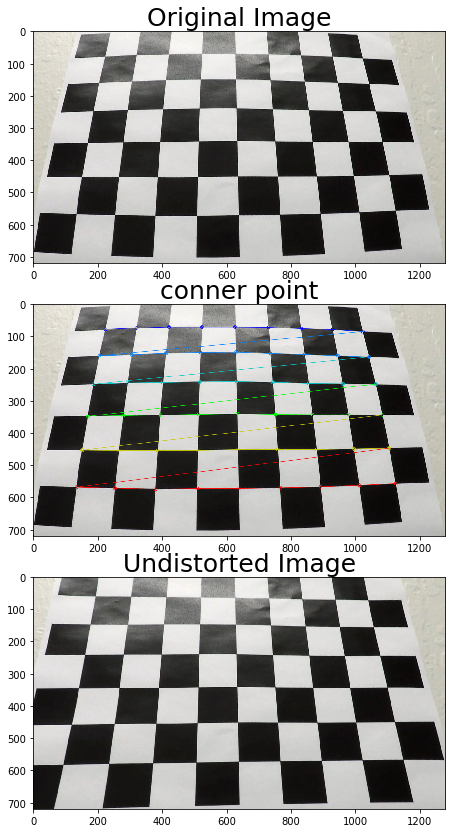

In [9]:
import numpy as np
from skimage import io
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import matplotlib.pyplot as plt
%matplotlib inline

ret00,images,objpoints,imgpoints= get_obj2img_points()

    
    
####################################################
#img_size = (img.shape[1], img.shape[0])
img_size=get_tuple_img_sizeYX()
ret01,mtx,dist=get_cal_undistort_param(img_size, objpoints, imgpoints)
####################################################


print(ret00)
print(ret01)

###################################################################################
import numpy as np
from skimage import io
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import matplotlib.pyplot as plt
%matplotlib inline

d=0
d=np.clip(d, 0, len(imgpoints))

img= io.imread(images[d])   

# Draw and display the corners
c_img = img.copy()
c_img = cv2.drawChessboardCorners(c_img, (9,6),imgpoints[d], ret00)
undistorted = img.copy()
undistorted= cv2.undistort(undistorted, mtx, dist, None, mtx)
    

f, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(16, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=25)
ax2.imshow(c_img)
ax2.set_title('conner point', fontsize=25)

ax3.imshow(undistorted)
ax3.set_title('Undistorted Image', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=1.2, bottom=0.)


src.shape (4, 2) s.shape (5, 2)


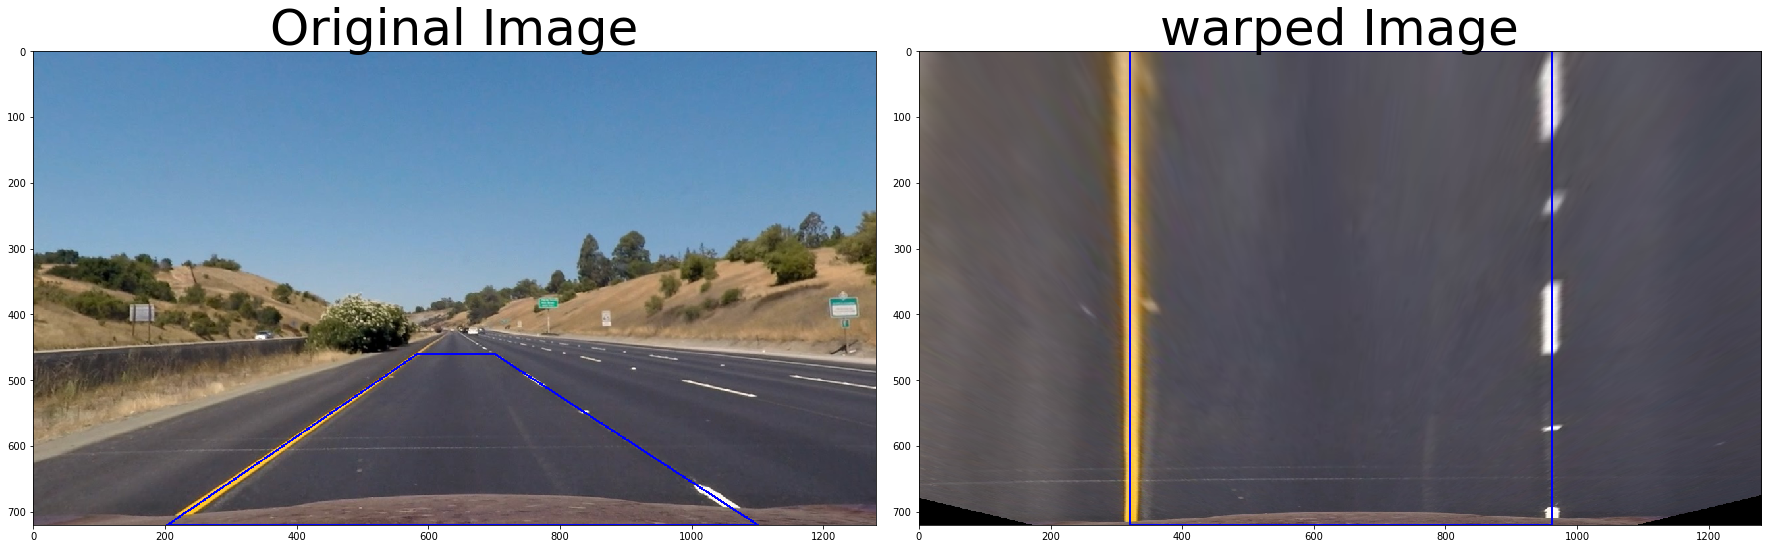

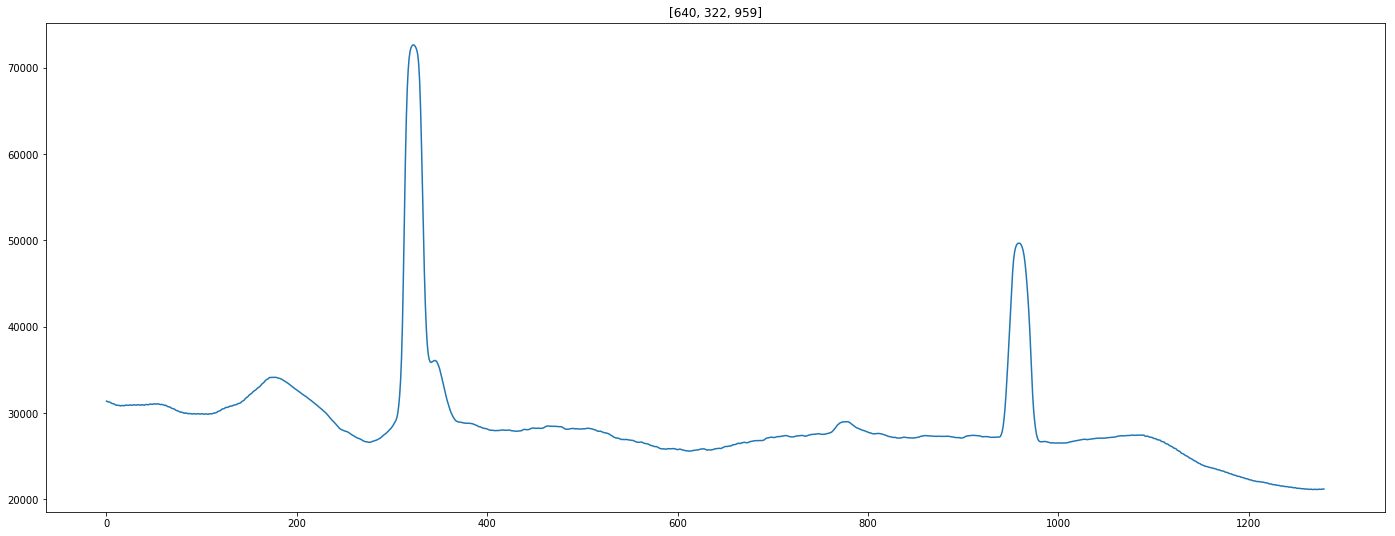

In [ ]:
from skimage import io    
import glob
sight=glob.glob('./test_images/straight_lines*.jpg')

img=io.imread(sight[0])
#img_size = (img.shape[1], img.shape[0])
#ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
M,src,dst=get_M_Matrix()
undist, warped=unwarp(img,mtx,dist,M)

disp=[undist.copy(),warped.copy()]
draw_lines_for_warp_operation(disp[0],disp[1],src,dst)


histogram, midpoint, leftx_base, rightx_base= get_warped_histogram_pack(warped)
plt.figure(figsize=(24, 9))
plt.plot(histogram)   
plt.title([midpoint, leftx_base, rightx_base])


In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
%matplotlib inline
import os.path


if os.path.exists('./test_warps/warp1.jpg')==False:
    sight=glob.glob('./test_images/test*.jpg')
    n=1
    for imfile in sight:
        img=io.imread(imfile)
        undist, warped=unwarp(img,mtx,dist,M)

        text='./test_warps/warp%d.jpg'%(n,)
        io.imsave(text,warped)
        n=n+1

sight=glob.glob('./test_warps/warp*.jpg')

n=0
for src_warped in sight :
    print(src_warped)
    warped=io.imread(src_warped )
    plt.figure(figsize=(32,15))
    
    gray , edge, declr= customize_image_for_lane_excute(warped)


    f, (ax1, ax2,ax3 ) = plt.subplots(1,3,figsize=(16, 6))
    f.tight_layout()
    ax1.imshow(warped)
    ax2.imshow(declr)
    ax3.imshow(gray)
    n=n+1  
    text='./test_warps/gray_warped%d.jpg'%(n,)
    io.imsave(text,gray)
        
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
plt.show()     
print('test')

./test_warps/warp3.jpg


/home/kshiba/conda/envs/carnd-term1/lib/python3.5/site-packages/skimage/io/_io.py:132: UserWarning: ./test_warps/gray_warped1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)


./test_warps/warp6.jpg
./test_warps/warp5.jpg


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

from skimage import io    
import glob
   
sight=glob.glob('./test_warps/gray_warped*.jpg')

for src_warped in sight:
    print(src_warped)
    gray=io.imread(src_warped)
    
    thresh = 100
    max_pixel = 255
    ret02, binary_warped = cv2.threshold(gray,thresh,max_pixel,cv2.THRESH_BINARY)

    left_lane_inds,right_lane_inds,nonspace,rect=sliding_detect_function(binary_warped,9,80,leftx_base,rightx_base)

    nonzero=nonspace[0]
    nonzerox=nonspace[1]    
    nonzeroy=nonspace[2]
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    print(out_img.shape,out_img.max(),binary_warped.max())
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    for l in rect[0]:
        cv2.rectangle(out_img,(l[0],l[1]),(l[2],l[3]),(0,255,0), 2) 
        
    for r in rect[1]:
        cv2.rectangle(out_img,(r[0],r[1]),(r[2],r[3]),(0,255,0), 2) 

        
    lfit,rfit,mfit,plotter,realfit=polynomial2ndfit(nonspace,left_lane_inds,right_lane_inds,leftx_base,rightx_base)
    text=get_str_poly_equation(realfit[2])
    
    font = cv2.FONT_ITALIC
    cv2.putText(out_img,text,(10,out_img.shape[0]-200) ,font, 1.5 ,(0,255,255),5,cv2.LINE_AA )
    
    
    R,curvature,text=   get_radius_of_curvature(yconv_warp2udist(out_img.shape[0]),realfit[2])
    cv2.putText(out_img,text,(10,out_img.shape[0]-300) ,font, 1.5 ,(0,255,255),5,cv2.LINE_AA )
    
    dx,rx,text=get_offset_of_centerline(mfit)
    cv2.putText(out_img,text,(10,out_img.shape[0]-400) ,font, 1.5 ,(255,255,255),5,cv2.LINE_AA )
    
    
    plt.figure(figsize=(13,6))
    plt.imshow(out_img)
    ploty=plotter[0]
    left_plotx=plotter[1]
    right_plotx=plotter[2]
    mid_plotx=plotter[3]
    
    plt.plot(right_plotx, ploty, color='yellow')
    plt.plot(left_plotx, ploty, color='yellow')
    plt.plot(mid_plotx, ploty, color='yellow')


    convL,convR,convM=convert_plotter_warp2undist(plotter[0],plotter[1],plotter[2],plotter[3])
    

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

from skimage import io    
import glob


####################################################
def ans_project_move_function(img,lastx_base,last_fit):
    ret00,images,objpoints,imgpoints= get_obj2img_points()
    ret01,mtx,dist=get_cal_undistort_param(get_tuple_img_sizeYX(), objpoints, imgpoints)
    M,src,dst=get_M_Matrix()
    undist, warped=unwarp(img,mtx,dist,M)
    gray , edge, declr= customize_image_for_lane_excute(warped)
 
    histogram, midpoint, leftx_base, rightx_base= get_warped_histogram_pack(warped)
    if len(lastx_base)==2 :
        xlast_l_base=lastx_base[0]
        xlast_r_base=lastx_base[1]
        if(xlast_l_base>0):
             leftx_base=(leftx_base+xlast_l_base)//2   
        if(xlast_r_base>0):
             rightx_base=(rightx_base+xlast_r_base)//2   
 
    thresh = 100
    max_pixel = 255
    ret02, binary_warped = cv2.threshold(gray,thresh,max_pixel,cv2.THRESH_BINARY)

    left_lane_inds,right_lane_inds,nonspace,rect=sliding_detect_function(binary_warped,9,80,leftx_base,rightx_base)


    lfit,rfit,mfit,plotter,realfit=polynomial2ndfit(nonspace,left_lane_inds,right_lane_inds,leftx_base,rightx_base)
    if len(last_fit)==3:
        lastl=last_fit[0]
        lastr=last_fit[1]
        lastm=last_fit[2]
        
        hist=[all(lastl!=np.zeros(lastl.shape)),all(lastr!=np.zeros(lastr.shape)),all(lastm!=np.zeros(lastm.shape))] 
                  
        if ((len(left_lane_inds)<10)and(hist[0]==True)):    
            lfit=lastl
            mfit ,plotter[0], plotter[1], plotter[2], plotter[3] =get_mid_fitting(lfit,rfit) 
        
        if ((len(right_lane_inds)<10)and(hist[1]==True)):
            rfit=lastr
            mfit ,plotter[0], plotter[1], plotter[2], plotter[3] =get_mid_fitting(lfit,rfit) 
        
    
    convL,convR,convM=convert_plotter_warp2undist(plotter[0],plotter[1],plotter[2],plotter[3])
    
    result= fill_current_lane(img,convL,convR)
    
    
    font = cv2.FONT_ITALIC
    
    R,curvature,text=   get_radius_of_curvature(yconv_warp2udist(result.shape[0]),realfit[2])
    cv2.putText(result,text,(10,100) ,font, 1.5 ,(0,255,255),5,cv2.LINE_AA )
    
    dx,rx,text=get_offset_of_centerline(mfit)
    cv2.putText(result,text,(10,150) ,font, 1.5 ,(255,255,255),5,cv2.LINE_AA )
   
    return result,[leftx_base,rightx_base],[lfit,rfit,mfit]
    

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
%matplotlib inline

target='./test_images/test1.jpg'
img=io.imread(target)
lastx_base=[-1,-1]
last_fit=[np.array([0,0,0]),np.array([0,0,0]),np.array([0,0,0])]
result,lastx_base,last_fit=ans_project_move_function(img,lastx_base,last_fit)

plt.figure(figsize=(16,7))
plt.imshow(result)

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import numpy as np
import cv2
import matplotlib.pyplot as plt


lastx_base=[-1,-1]
last_fit=[np.array([0,0,0]),np.array([0,0,0]),np.array([0,0,0])]

def process_image(image):
    global lastx_base
    global last_fit
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    # TODO: Build your pipeline that will draw lane lines on the test_images
    # then save them to the test_images directory.

    # TODO: Build your pipeline that will draw lane lines on the test_images
    # then save them to the test_images directory.

    import datetime
    
    
    result,lastx_base,last_fit=ans_project_move_function(image,lastx_base,last_fit)


    now = datetime.datetime.now()
    font = cv2.FONT_ITALIC
    result =cv2.putText(result,str(now),(10,50) ,font, 1.5 ,(255,255,255),5,cv2.LINE_AA )
 

    return result



In [ ]:
prj_output = 'videos_output/project_ans02.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)

#clip1  = VideoFileClip("./project_video.mp4").subclip(0,5)
clip1  = VideoFileClip("./project_video.mp4")


#white_clip  =  clip1.fl_image(test_image) #NOTE: this function expects color images!!
white_clip  =  clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(prj_output, audio=False)



In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(prj_output))
